In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Loading MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Split training/validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=10000, random_state=42
)


In [5]:
# Normalization
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# add channel dims (28, 28, 1)
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# one-hot encode cuz only recongnize 0~9
train_labels = tf.one_hot(train_labels, 10)
val_labels = tf.one_hot(val_labels, 10)
test_labels = tf.one_hot(test_labels, 10)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


c:\Users\ChuangE\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
#Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model and add validation data
history = model.fit(train_images, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, val_labels))


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9907 - val_loss: 0.0304
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9886 - loss: 0.0345 - val_accuracy: 0.9927 - val_loss: 0.0284
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9905 - loss: 0.0309 - val_accuracy: 0.9926 - val_loss: 0.0306
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9889 - loss: 0.0333 - val_accuracy: 0.9932 - val_loss: 0.0304
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9920 - loss: 0.0255 - val_accuracy: 0.9928 - val_loss: 0.0303
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9912 - loss: 0.0275 - val_accuracy: 0.9926 - val_loss: 0.0321
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9908 - loss: 0.0299 - val_accuracy: 0.9927 - val_loss: 0.0302
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9902 - loss: 0.0289 - 

In [14]:
model.save('mnist_cnn_model.keras')

# Reload model
model = tf.keras.models.load_model('mnist_cnn_model.keras')


In [15]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(test_labels.numpy(), axis=1)

# Test predict result
for i in range(10):
    print(f"Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Actual: 7, Predicted: 7
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 4, Predicted: 4
Actual: 1, Predicted: 1
Actual: 4, Predicted: 4
Actual: 9, Predicted: 9
Actual: 5, Predicted: 5
Actual: 9, Predicted: 9


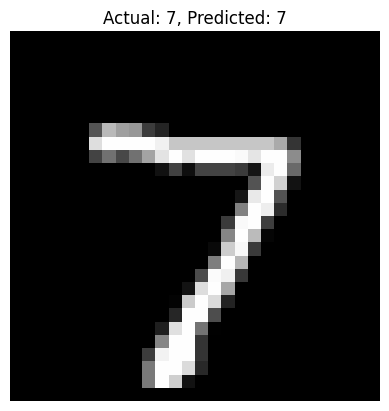

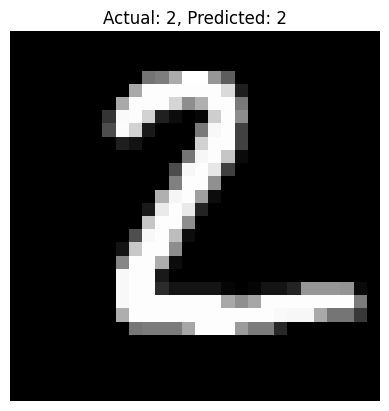

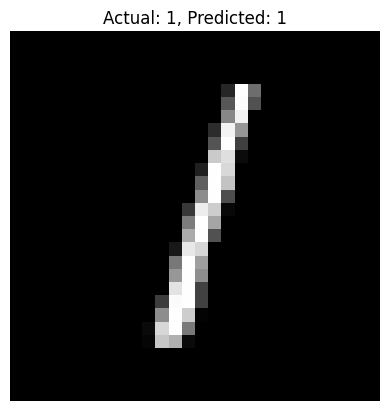

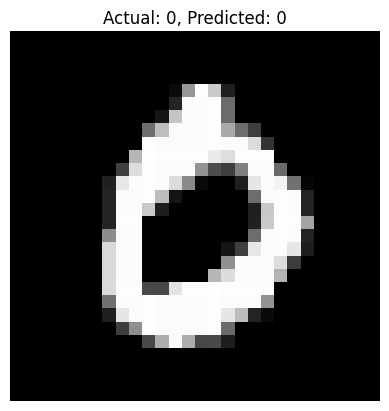

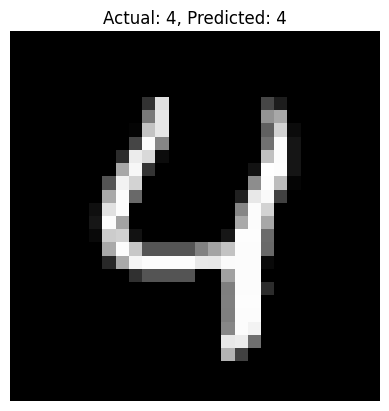

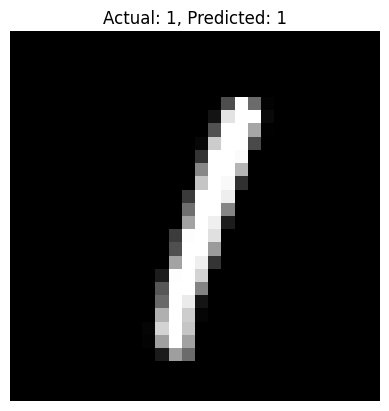

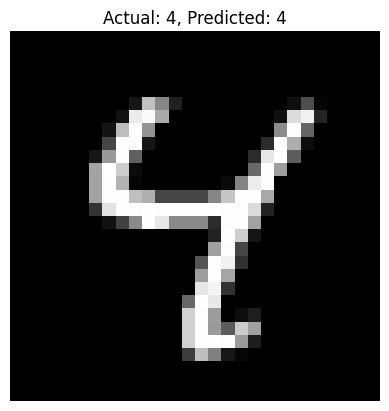

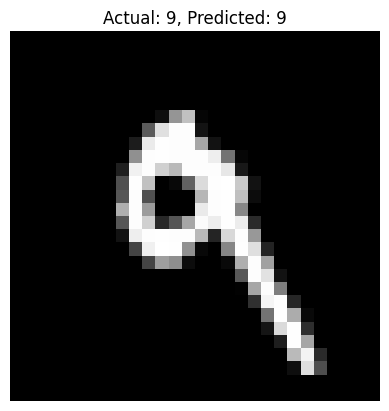

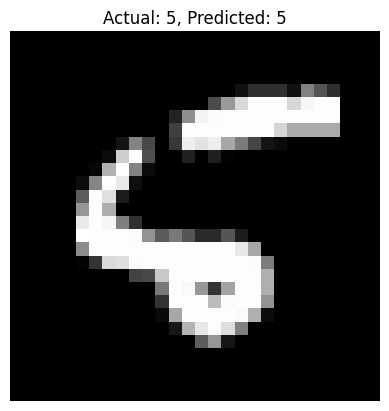

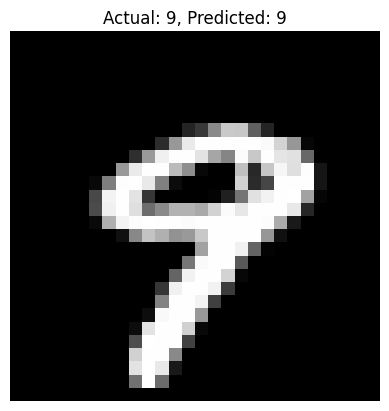

In [16]:
#Show the images of the test result
for i in range(10):
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f"Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()


In [17]:
#Create a writting board to write and recognize
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('mnist_cnn_model.keras')

class DigitRecognizerApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Handwritten recognition")
        self.canvas_width = 280
        self.canvas_height = 280

        self.canvas = tk.Canvas(master, width=self.canvas_width, height=self.canvas_height, bg='white')
        self.canvas.pack()

        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 255)
        self.draw = ImageDraw.Draw(self.image)

        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<ButtonRelease-1>", self.reset)

        self.result_label = tk.Label(master, text="Predict Result：", font=("Arial", 16))
        self.result_label.pack()

        self.predict_button = tk.Button(master, text="Recognize", command=self.predict_digit)
        self.predict_button.pack(side=tk.LEFT, padx=10, pady=10)

        self.clear_button = tk.Button(master, text="Clear", command=self.clear_canvas)
        self.clear_button.pack(side=tk.RIGHT, padx=10, pady=10)

        self.last_x, self.last_y = None, None

    def paint(self, event):
        if self.last_x and self.last_y:
            self.canvas.create_line(self.last_x, self.last_y, event.x, event.y,
                                    width=12, fill='black', capstyle=tk.ROUND, smooth=tk.TRUE, splinesteps=36)
            self.draw.line([self.last_x, self.last_y, event.x, event.y], fill=0, width=12)
        self.last_x = event.x
        self.last_y = event.y

    def reset(self, event):
        self.last_x, self.last_y = None, None

    def clear_canvas(self):
        self.canvas.delete("all")
        self.draw.rectangle([0, 0, self.canvas_width, self.canvas_height], fill=255)
        self.result_label.config(text="Predict Result：")

    def predict_digit(self):
        # Pre-process：rescale、reverse 、normalization
        image = self.image.resize((28, 28))
        image = ImageOps.invert(image)
        img_array = np.array(image) / 255.0
        img_array = img_array.reshape(1, 28, 28, 1)

        # Prediction
        prediction = model.predict(img_array)
        digit = np.argmax(prediction)
        confidence = np.max(prediction)

        self.result_label.config(text=f"Predict Result：{digit}（Confidence Value：{confidence:.2f}）")

if __name__ == '__main__':
    root = tk.Tk()
    app = DigitRecognizerApp(root)
    root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
